In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-05 09:00:00+09:00,51010.281250,51508.828125,50995.671875,51355.660156,0,0.0,0.0
2026-01-05 09:15:00+09:00,51380.250000,51618.148438,51380.250000,51545.820312,0,0.0,0.0
2026-01-05 09:30:00+09:00,51540.429688,51608.730469,51498.468750,51584.589844,0,0.0,0.0
2026-01-05 09:45:00+09:00,51569.960938,51714.019531,51569.960938,51699.449219,0,0.0,0.0
2026-01-05 10:00:00+09:00,51695.988281,51743.960938,51623.539062,51648.558594,0,0.0,0.0
2026-01-05 10:15:00+09:00,51653.140625,51778.558594,51613.218750,51772.578125,0,0.0,0.0
2026-01-05 10:30:00+09:00,51772.699219,51816.718750,51752.050781,51758.929688,0,0.0,0.0
2026-01-05 10:45:00+09:00,51757.609375,51757.609375,51612.019531,51655.238281,0,0.0,0.0
2026-01-05 11:00:00+09:00,51655.839844,51757.320312,51655.839844,51708.890625,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-01-05 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-01-05 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-12-29 00:00:00+09:00    50526.921875
2025-12-30 00:00:00+09:00    50339.480469
2026-01-05 00:00:00+09:00    51915.429688
Name: Close, dtype: float64


Date
2025-12-30 00:00:00+09:00    50339.480469
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+670.80


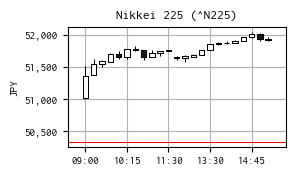

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-02 09:00:00+09:00,156.720001,156.770996,156.634995,156.694000,0,0.0,0.0
2026-01-02 09:15:00+09:00,156.697006,156.751007,156.688995,156.725998,0,0.0,0.0
2026-01-02 09:30:00+09:00,156.725998,156.735001,156.647003,156.662994,0,0.0,0.0
2026-01-02 09:45:00+09:00,156.673004,156.677002,156.533997,156.565002,0,0.0,0.0
2026-01-02 10:00:00+09:00,156.565002,156.606995,156.509003,156.589005,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-05 14:30:00+09:00,157.190002,157.190002,157.108994,157.123001,0,0.0,0.0
2026-01-05 14:45:00+09:00,157.128006,157.195999,157.110001,157.175995,0,0.0,0.0
2026-01-05 15:00:00+09:00,157.179001,157.231995,157.139008,157.169998,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-01-05 09:00:00+09:00,324.658114,327.831146,324.565131,326.856299
2026-01-05 09:15:00+09:00,327.031541,328.545747,327.031541,328.085384
2026-01-05 09:30:00+09:00,327.892452,328.326971,327.625503,328.173392
2026-01-05 09:45:00+09:00,328.167995,329.084719,328.167995,328.992000
2026-01-05 10:00:00+09:00,329.080983,329.386363,328.619794,328.779060
2026-01-05 10:15:00+09:00,328.653402,329.451398,328.399391,329.413346
2026-01-05 10:30:00+09:00,329.754019,330.034391,329.622503,329.666317
2026-01-05 10:45:00+09:00,329.649514,329.649514,328.722237,328.997502
2026-01-05 11:00:00+09:00,329.026466,329.672855,329.026466,329.364378


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-01-02 15:15:00+09:00


np.float64(156.9510040283203)

前日終値（ドル換算） 320.7337269385465


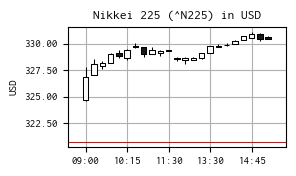

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()